In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

import torch_nf
import torch_nf.density_estimator as de
from torch_nf.conditional_density_estimator import ConditionalDensityEstimator
from torch_nf.error_formatters import dbg_check
from torch_nf.systems import Toy
from torch_nf.util import plot_dist
from torch_nf.lfi import train_SNPE, train_APT
from torch_nf.bijectors import ToInterval

import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Define system
N = 4
system = Toy(N)

z0 = np.array([[0.7, -2.9, -1., -0.9, 0.6]])
x0 = system.simulate(z0)
print('x_0', x0, x0.shape)

x_0 [[ 2.09266005 -3.28400865 -0.34090774 -2.21891585  1.10891871 -1.92559271
   1.29325336 -1.93806441]] (1, 8)


In [3]:
# Opt params
D = system.D
M = 1000
M_atom = 100
num_iters = 500
R = 3

# two-network arch
arch_type = 'AR'
hidden_layers = [64, 64]

rs = 1
np.random.seed(rs)
torch.manual_seed(rs)

lb = system.lb#-float('inf')*np.ones((D,))
ub = system.ub#float('inf')*np.ones((D,))
support_layer = ToInterval(D, lb, ub)


if (arch_type == 'AR'):
    density_estimator = de.NormFlow(
        D, True, arch_type, num_stages=1, 
        num_layers=1, num_units=20, 
        support_layer=support_layer
    )
elif (arch_type == 'MoG'):
    density_estimator = de.MoG(
        D, 
        True, 
        K=1,
    )
print(density_estimator)

In [4]:
cde = ConditionalDensityEstimator(density_estimator, x0.shape[1], hidden_layers, dropout=False)

### Run SNPE

In [5]:
cde, losses, zs, log_probs, it_time, sample_times = train_APT(
    cde, 
    system, 
    x0, 
    M=M,
    M_atom=M_atom,
    R=R, 
    num_iters=num_iters, 
    z0=z0[0],
    verbose=False,
)

r 1
Cumulative valid proposals: 1000
r 1, it 1, loss=1.01E+01, time/it=0.045s
r 1, it 25, loss=8.05E+00, time/it=0.042s
r 1, it 50, loss=7.14E+00, time/it=0.043s
r 1, it 75, loss=6.67E+00, time/it=0.041s
r 1, it 100, loss=6.45E+00, time/it=0.046s
r 1, it 125, loss=6.34E+00, time/it=0.041s
r 1, it 150, loss=6.07E+00, time/it=0.042s
r 1, it 175, loss=5.99E+00, time/it=0.044s
r 1, it 200, loss=5.96E+00, time/it=0.046s
r 1, it 225, loss=5.71E+00, time/it=0.046s
r 1, it 250, loss=5.64E+00, time/it=0.041s
r 1, it 275, loss=5.55E+00, time/it=0.045s
r 1, it 300, loss=5.47E+00, time/it=0.041s
r 1, it 325, loss=5.36E+00, time/it=0.042s
r 1, it 350, loss=5.32E+00, time/it=0.040s
r 1, it 375, loss=5.24E+00, time/it=0.042s
r 1, it 400, loss=5.18E+00, time/it=0.044s
r 1, it 425, loss=4.97E+00, time/it=0.042s
r 1, it 450, loss=5.40E+00, time/it=0.042s
r 1, it 475, loss=4.96E+00, time/it=0.043s
r 1, it 500, loss=4.75E+00, time/it=0.042s
Cumulative valid proposals: 1000
r 2
Cumulative valid proposals: 

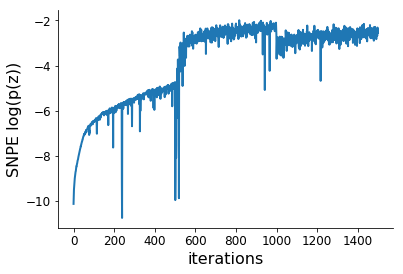

In [6]:
plt.figure()
plt.plot(-losses)
plt.xlabel('iterations')
plt.ylabel('SNPE log(p(z))')
plt.show()

In [7]:
print(cde.density_estimator)

In [8]:
x0_torch = torch.tensor(x0).float()
params = cde.param_net(x0_torch)
alpha, mu, Sigma_inv, Sigma_det = cde.density_estimator._get_MoG_params(params)

AttributeError: 'NormFlow' object has no attribute '_get_MoG_params'

In [9]:
print(alpha)
print(mu)
print(Sigma_inv)

NameError: name 'alpha' is not defined

<Figure size 432x288 with 0 Axes>

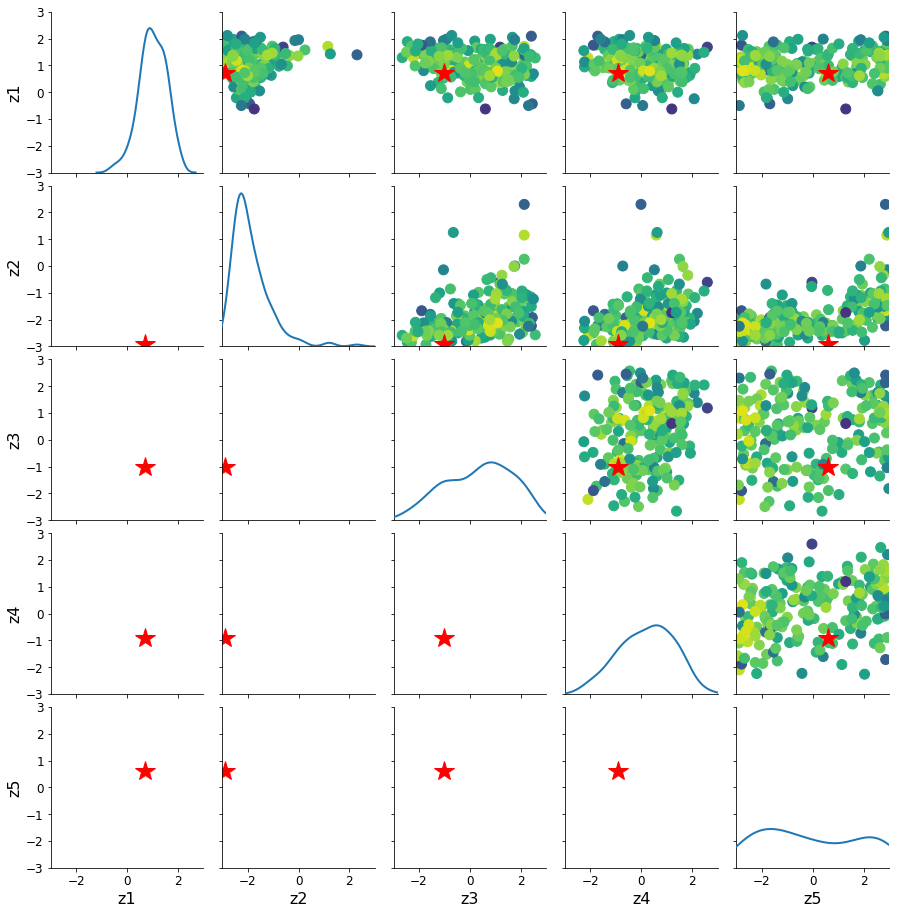

In [10]:
ind = 3
plt.figure()
g = plot_dist(zs[ind], log_probs[ind], z0=z0[0], lb=system.lb, ub=system.ub)
plt.show()